In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23a

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dataset From CSV File

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
### Import Libraries

import tensorflow as tf

import os

#import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
%matplotlib inline

2022-06-22 17:43:51.822207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:43:51.865898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:43:51.866204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 20 # number of cycles to run


BATCH_SIZE = 16 # inline of Traing Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [5]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [6]:
def fn_plot_label(train_df, test_df):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [7]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [8]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


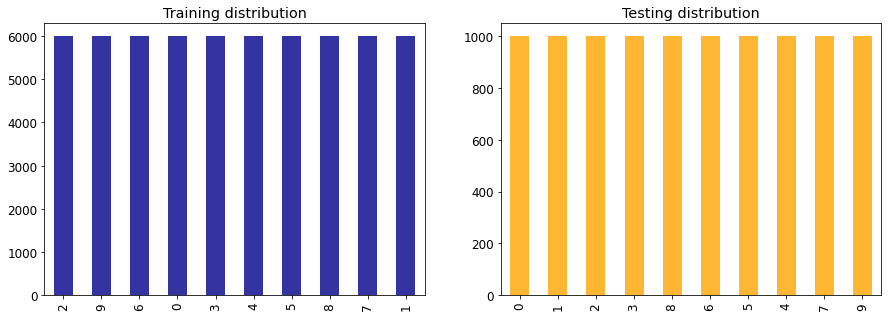

In [11]:
fn_plot_label(train_df, test_df)

## Converting to Datasets